In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 20.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909879 sha256=84f9f4a60121deb5d2079524562396dc54effac30cbad379d22b59c64ae33b84
  Stored in directory: /root/.cache/pip/wheels/47/16/75/ac3099e3ea0348d3e241a8230d1fe50b202badaf5d89ae1825
Successfully built torch-geometric
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread

# Pytorch Libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
import torch_geometric.transforms as T
import torch_geometric

from torch.optim import lr_scheduler
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC

sns.set()

In [3]:
meta_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
meta_data = meta_data.groupby('label', group_keys=False).apply(lambda x: x.sample(2500))
meta_data.reset_index(drop=True, inplace=True)
meta_data.shape

(5000, 2)

In [4]:
meta_data.head()

,id,label
0,686dce644f9e4288942a3f3e13353063ec9676b1,0
1,19f0392c25e069d6b6e35f3c0e37eafd2578a48e,0
2,838ffd8360b83d5596280ce53bb8455b91b5aad8,0
3,9d8fe880cf64cf4f82377b0bb19e5f6516783642,0
4,23dcfe456bab9d6b223e93f338ab2a3a29082030,0


In [5]:
base_dir = os.path.join('..', 'input/histopathologic-cancer-detection/train')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(base_dir,'*.tif'))}

meta_data['path'] = meta_data['id'].map(imageid_path_dict.get)
meta_data.head()

,id,label,path
0,686dce644f9e4288942a3f3e13353063ec9676b1,0,../input/histopathologic-cancer-detection/trai...
1,19f0392c25e069d6b6e35f3c0e37eafd2578a48e,0,../input/histopathologic-cancer-detection/trai...
2,838ffd8360b83d5596280ce53bb8455b91b5aad8,0,../input/histopathologic-cancer-detection/trai...
3,9d8fe880cf64cf4f82377b0bb19e5f6516783642,0,../input/histopathologic-cancer-detection/trai...
4,23dcfe456bab9d6b223e93f338ab2a3a29082030,0,../input/histopathologic-cancer-detection/trai...


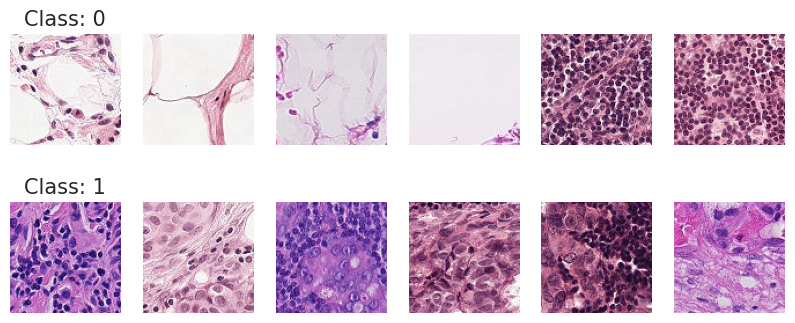

In [6]:
n_samples = 6
n_classes = len(meta_data['label'].unique())
df = meta_data.sort_values(['label']).groupby('label')
fig, axs = plt.subplots(n_classes, n_samples, figsize = (10, 4))
for ax, (type_, rows) in zip(axs, df):
    ax[0].set_title('Class: '+ str(type_), fontsize=15)
    for sub_ax, (_, subset) in zip(ax, rows.sample(n_samples).iterrows()):
        img = imread(subset['path'])
        sub_ax.imshow(img)
        sub_ax.axis('off')

In [7]:
data = []
outliers = []
for path in meta_data['path']:
    img = cv2.imread(path)
        
    avgR = np.mean(img[:,:,2])
    avgG = np.mean(img[:,:,1])
    avgB = np.mean(img[:,:,0])
    RGB = np.mean([avgR, avgG, avgB])
    
    data.append([avgR, avgG, avgB, RGB])
    
    if ((RGB <= 45) or (RGB >= 245)) : outliers.append(meta_data.loc[meta_data['path'] == path].index[0])
    
rgb = pd.DataFrame(data, columns=['Red Channel Mean','Green Channel Mean','Blue Channel Mean', 'RGB Mean'])

meta_data = pd.concat([meta_data.reset_index(drop=True), rgb], axis=1)

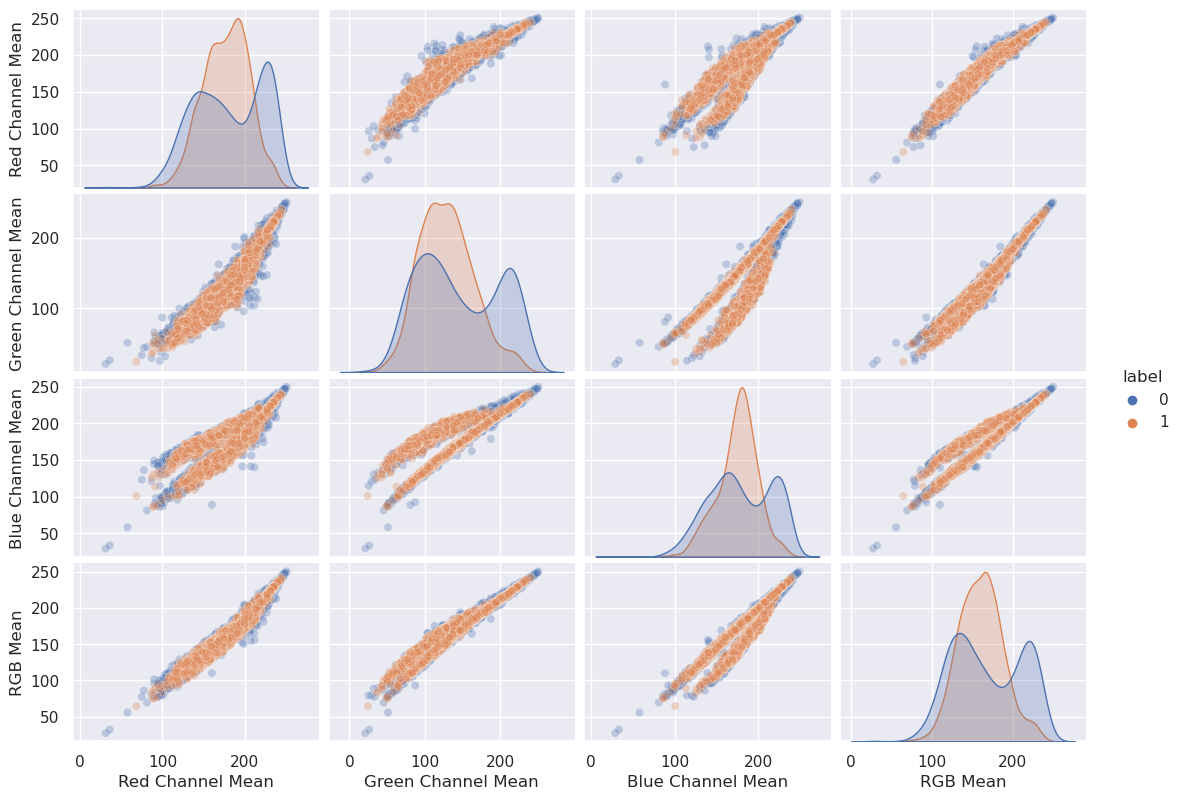

In [8]:
g = sns.pairplot(meta_data[['Red Channel Mean', 'Green Channel Mean', 'Blue Channel Mean', 'RGB Mean', 'label']],
             hue='label', plot_kws = {'alpha': 0.3})

g.fig.set_size_inches(12,8)

In [9]:
len(outliers)

13

In [10]:
extremely_low_pxl_img = meta_data[meta_data['RGB Mean'] <= 45]
extremely_high_pxl_img = meta_data[meta_data['RGB Mean'] >= 245]

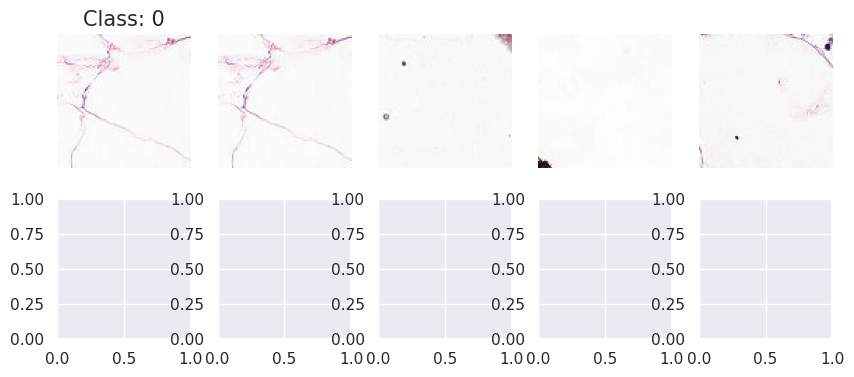

In [11]:
n_samples = 5
df = extremely_high_pxl_img.sort_values(['label']).groupby('label')
fig, axs = plt.subplots(2, n_samples, figsize = (10, 4))
for ax, (type_, rows) in zip(axs, df):
    ax[0].set_title('Class: '+ str(type_), fontsize=15)
    for sub_ax, (_, subset) in zip(ax, rows.sample(n_samples, replace = True).iterrows()):
        img = imread(subset['path'])
        sub_ax.imshow(img)
        sub_ax.axis('off')

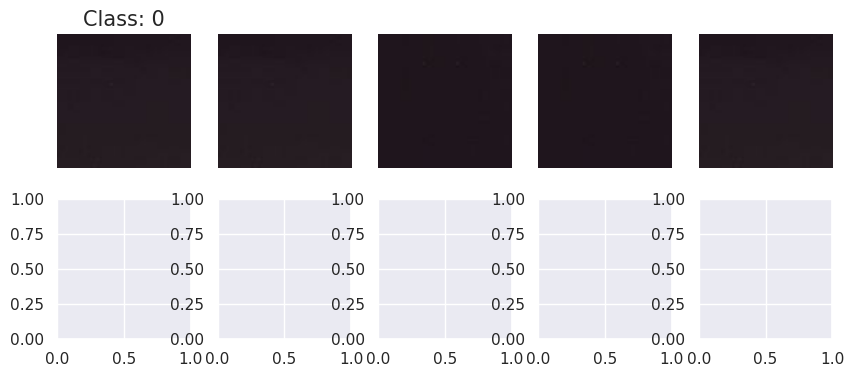

In [12]:
n_samples = 5
df = extremely_low_pxl_img.sort_values(['label']).groupby('label')
fig, axs = plt.subplots(2, n_samples, figsize = (10, 4))
for ax, (type_, rows) in zip(axs, df):
    ax[0].set_title('Class: '+ str(type_), fontsize=15)
    for sub_ax, (_, subset) in zip(ax, rows.sample(n_samples, replace = True).iterrows()):
        img = imread(subset['path'])
        sub_ax.imshow(img)
        sub_ax.axis('off')

In [13]:
meta_data = meta_data.drop(outliers)
meta_data['label'].value_counts()

1    2500
0    2487
Name: label, dtype: int64

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        img_path = self.data_df.iloc[index]['path']
        label = self.data_df.iloc[index]['label']
        
        # Load image from file
        img = Image.open(img_path).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label

# Split data into train and test sets
train_df, test_df = train_test_split(meta_data, test_size=0.2, random_state=42)

In [15]:
# Define the batch size
batch_size = 32

In [16]:
# Define the data transforms for training and testing datasets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the data
train_dataset = CustomDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_df, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
def evaluate1(model, loader, criterion):
    correct = 0
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    acc = correct / total
    avg_loss = total_loss / len(loader)
    model.train()
    return acc, avg_loss

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Training ResNet50 model
Epoch [1/20], Loss: 0.3277, Accuracy: 79.19%
Accuracy of the network on the validation set: 78 %
Epoch [2/20], Loss: 0.4464, Accuracy: 82.28%
Accuracy of the network on the validation set: 78 %
Epoch [3/20], Loss: 0.1899, Accuracy: 83.96%
Accuracy of the network on the validation set: 85 %
Epoch [4/20], Loss: 0.3338, Accuracy: 85.71%
Accuracy of the network on the validation set: 85 %
Epoch [5/20], Loss: 0.3991, Accuracy: 85.18%
Accuracy of the network on the validation set: 82 %
Epoch [6/20], Loss: 0.1429, Accuracy: 86.84%
Accuracy of the network on the validation set: 80 %
Epoch [7/20], Loss: 0.4965, Accuracy: 87.32%
Accuracy of the network on the validation set: 84 %
Epoch [8/20], Loss: 0.3577, Accuracy: 87.01%
Accuracy of the network on the validation set: 87 %
Epoch [9/20], Loss: 0.3235, Accuracy: 87.49%
Accuracy of the network on the validation set: 85 %
Epoch [10/20], Loss: 0.1333, Accuracy: 87.92%
Accuracy of the network on the validation set: 88 %
Epoch

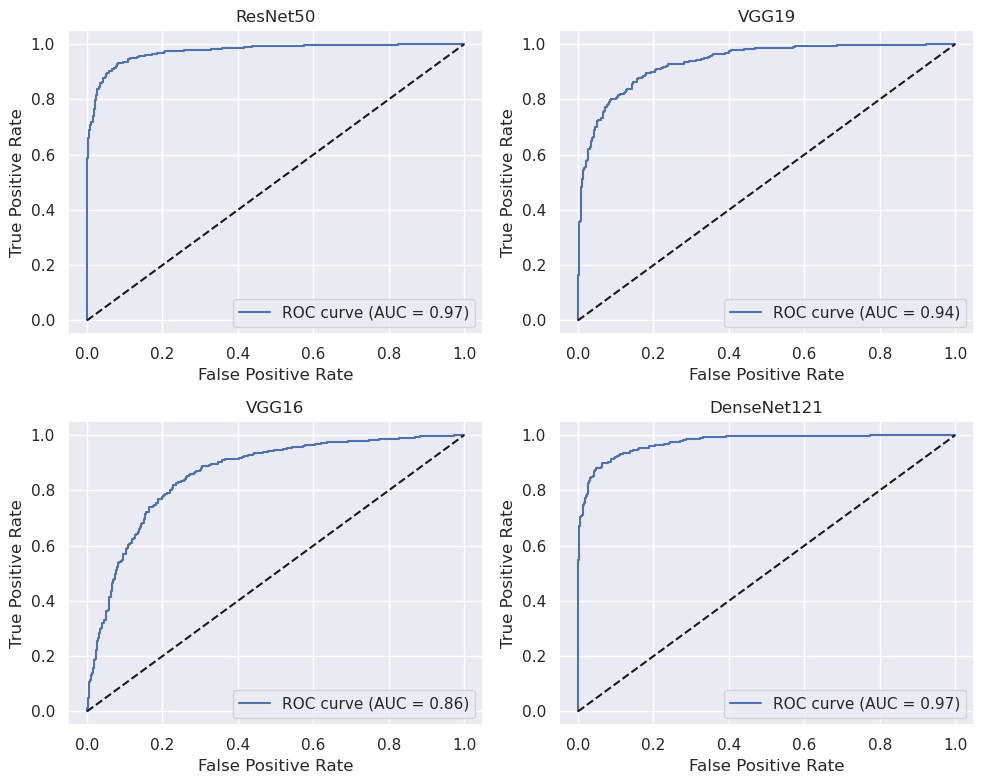

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define hyperparameters
learning_rate = 0.001
num_epochs = 20
roc_aucs = []

# define binary cross entropy loss
criterion = nn.BCEWithLogitsLoss()

# define ResNet50, VGG19, Inception, and DenseNet121 models
models_dict = {'ResNet50': models.resnet50(weights='DEFAULT'),
               'VGG19': models.vgg19(weights='DEFAULT'),
              'VGG16': models.vgg16(weights='DEFAULT'),
              'DenseNet121': models.densenet121(weights='DEFAULT')}

# define empty lists to store accuracy and loss
accs = []
losses = []

# loop over models
for model_name, model in models_dict.items():
    
    print('Training', model_name, 'model')
    
    if (model_name == 'VGG19') | (model_name == 'VGG16'):
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 512)
        model.classifier.add_module('bn1', nn.BatchNorm1d(512))
        model.classifier.add_module('relu1', nn.ReLU(inplace=True))
        model.classifier.add_module('dropout1', nn.Dropout())
        model.classifier.add_module('fc2', nn.Linear(512, 256))
        model.classifier.add_module('bn2', nn.BatchNorm1d(256))
        model.classifier.add_module('relu2', nn.ReLU(inplace=True))
        model.classifier.add_module('dropout2', nn.Dropout())
        model.classifier.add_module('fc3', nn.Linear(256, 1))
    else:
        if model_name == 'DenseNet121':
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Linear(num_ftrs, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(256, 1)
            )
        else:
            num_ftrs = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Linear(num_ftrs, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(256, 1)
            )

    model.to(device)
    
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    # define empty lists to store predictions and labels
    y_preds = []
    y_trues = []
    # train the model
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        total = 0
        correct = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # calculate accuracy
            total += labels.size(0)
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            acc = correct / total

            # append accuracy and loss to the lists
            accs.append(acc)
            losses.append(loss.item())

            # append predictions and labels to the lists
            y_preds += predicted.cpu().detach().numpy().tolist()
            y_trues += labels.cpu().detach().numpy().tolist()

        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, loss.item(), acc*100))
        
        # calculate validation accuracy and loss
        val_acc, val_loss = evaluate1(model, test_loader, criterion)
        print('Accuracy of the network on the validation set: %d %%' % (100 * val_acc))

        # adjust learning rate based on validation loss
        scheduler.step(val_loss)
        
    torch.save(model.state_dict(), model_name + '.pt')

# Plot AUC ROC Curve
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for i, (name, model) in enumerate(models_dict.items()):
    model.eval()
    y_score = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model = model.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            y_score.extend(outputs.cpu().numpy()[:, 0])
            y_true.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    axs[i].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axs[i].plot([0, 1], [0, 1], 'k--')
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(name)
    axs[i].legend(loc="lower right")
    plt.tight_layout()
plt.show()

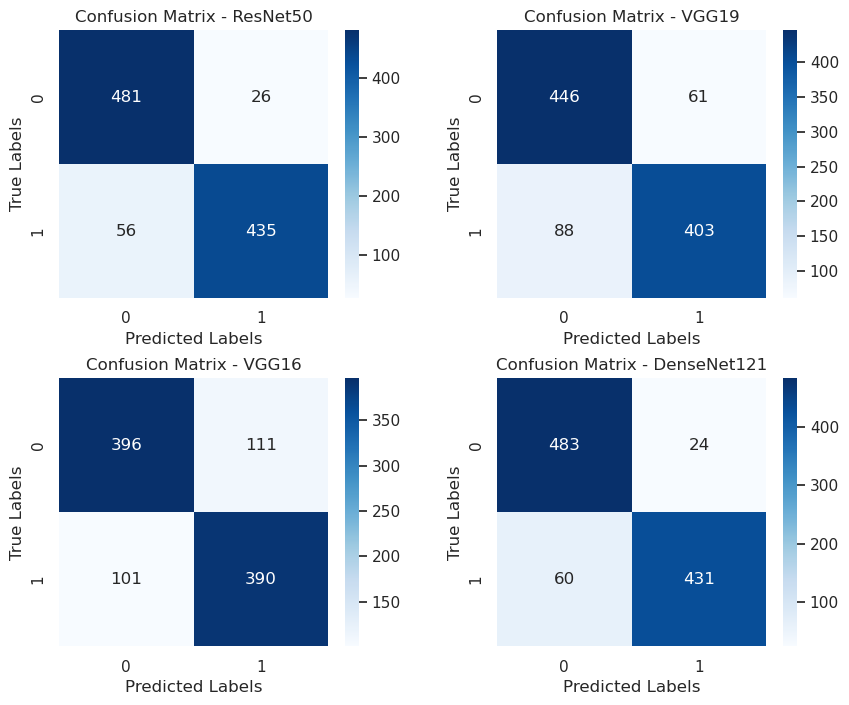

In [19]:
# Plot Confusion Matrix
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

# Loop through each model and plot its confusion matrix in a subplot
for i, (name, model) in enumerate(models_dict.items()):
    model.eval()
    y_pred = []
    y_true = []
    threshold = 0.5
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model = model.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            output_numpy = outputs.cpu().numpy()
            lab = (output_numpy >= threshold).astype(int)
            y_pred.extend(lab.tolist())
            y_true.extend(labels.cpu().numpy())
            
    y_pred = list(np.array(y_pred).flat)
    ax = axs[i]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt="g")
    ax.set_title("Confusion Matrix - {}".format(name))
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()

# Ensemble Model

In [20]:
def evaluate(model, loader, criterion):
    correct = 0
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            predicted = torch.round(outputs) # round the outputs to 0 or 1
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    acc = correct / total
    avg_loss = total_loss / len(loader)
    model.train()
    return acc, avg_loss

In [21]:
class Ensemble(nn.Module):
    def __init__(self, models_dict):
        super(Ensemble, self).__init__()
        self.models_dict = models_dict
        
    def forward(self, x):
        count = 0
        predicted = 0
        for model_name, model in self.models_dict.items():
            if model_name == 'VGG19':
                count += 0.225*torch.sigmoid(model(x))
            if model_name == 'VGG16':
                count += 0.225*torch.sigmoid(model(x))
            if model_name == 'ResNet50':
                count += 0.275*torch.sigmoid(model(x))
            if model_name == 'DenseNet121':
                count += 0.275*torch.sigmoid(model(x))

        return torch.tensor(count, dtype=torch.float32)
        
    
ensemble = Ensemble(models_dict)

ensemble.to(device)

val_acc, val_loss = evaluate(ensemble, test_loader, criterion)
print('Accuracy of the ensemble on the validation set: %d %%' % (100 * val_acc))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the ensemble on the validation set: 92 %


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


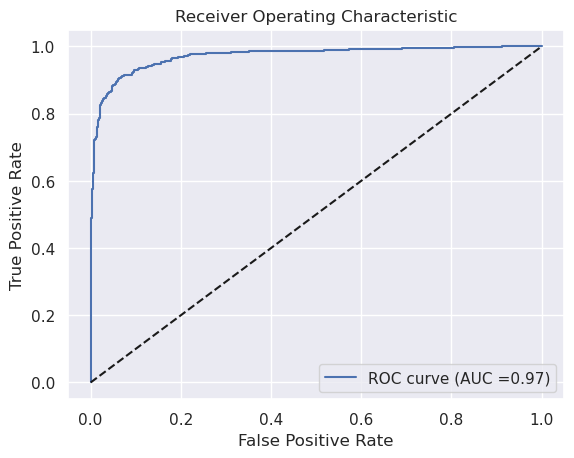

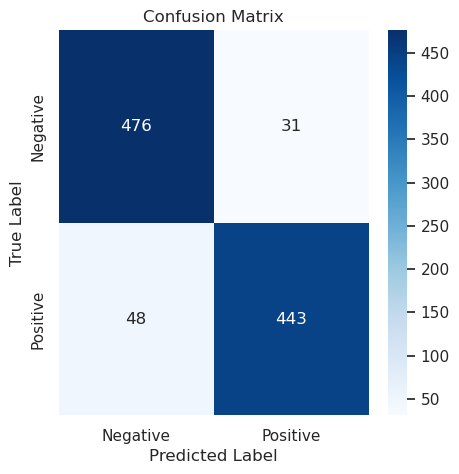

In [22]:
# Evaluate the model on the test set
y_test_preds = []
y_test_trues = []
predlist = []

ensemble.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ensemble(images)
        predicted = torch.round(outputs)
        predlist += predicted.cpu().detach().numpy().tolist()
        outputs = torch.sigmoid(outputs)
        y_test_preds += outputs.cpu().detach().numpy().tolist()
        y_test_trues += labels.cpu().detach().numpy().tolist()

       

# Calculate AUC ROC score
auc_roc_score = roc_auc_score(y_test_trues, y_test_preds)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_trues, y_test_preds)

plt.plot(fpr, tpr, label=f'ROC curve (AUC =%.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_trues, predlist)

# Plot confusion matrix
labels = ['Negative', 'Positive']
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Custom Binary Classification CNN Model

In [23]:
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.pool(nn.functional.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 6 * 6)
        x = nn.functional.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [24]:
# Set the hyperparameters
batch_size = 32

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Create the datasets and data loaders
dataset_train = CustomDataset(train_df, transform=train_transforms)
dataset_valid = CustomDataset(test_df, transform=test_transforms)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size)

In [25]:
learning_rate = 0.005

# Initialize the model, criterion, and optimizer
model = BinaryCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [26]:
# Train the model
accs = []
losses = []
y_preds = []
y_trues = []
count = 0
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(loader_train, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
                
        # calculate accuracy
        total += labels.size(0)
        predicted = torch.round(outputs)
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        acc = correct / total

        # append accuracy and loss to the lists
        accs.append(acc)
        losses.append(loss.item())

        # append predictions and labels to the lists
        y_preds += predicted.cpu().detach().numpy().tolist()
        y_trues += labels.cpu().detach().numpy().tolist()
        
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, loss.item(), acc*100))
    
    # calculate validation accuracy and loss
    val_acc, val_loss = evaluate(model, loader_valid, criterion)
    print('Accuracy of the network on the validation set: %d %%' % (100 * val_acc))
    
    # adjust learning rate based on validation loss
    scheduler.step(val_loss)

[1,   100] loss: 0.613
Epoch [1/20], Loss: 0.6499, Accuracy: 70.07%
Accuracy of the network on the validation set: 74 %
[2,   100] loss: 0.567
Epoch [2/20], Loss: 0.5303, Accuracy: 72.30%
Accuracy of the network on the validation set: 73 %
[3,   100] loss: 0.562
Epoch [3/20], Loss: 0.5752, Accuracy: 73.20%
Accuracy of the network on the validation set: 74 %
[4,   100] loss: 0.556
Epoch [4/20], Loss: 0.4912, Accuracy: 73.55%
Accuracy of the network on the validation set: 75 %
[5,   100] loss: 0.532
Epoch [5/20], Loss: 0.3534, Accuracy: 74.43%
Accuracy of the network on the validation set: 76 %
[6,   100] loss: 0.531
Epoch [6/20], Loss: 0.4805, Accuracy: 75.31%
Accuracy of the network on the validation set: 73 %
[7,   100] loss: 0.523
Epoch [7/20], Loss: 0.7385, Accuracy: 75.31%
Accuracy of the network on the validation set: 78 %
[8,   100] loss: 0.513
Epoch [8/20], Loss: 0.3500, Accuracy: 75.73%
Accuracy of the network on the validation set: 78 %
[9,   100] loss: 0.507
Epoch [9/20], Los

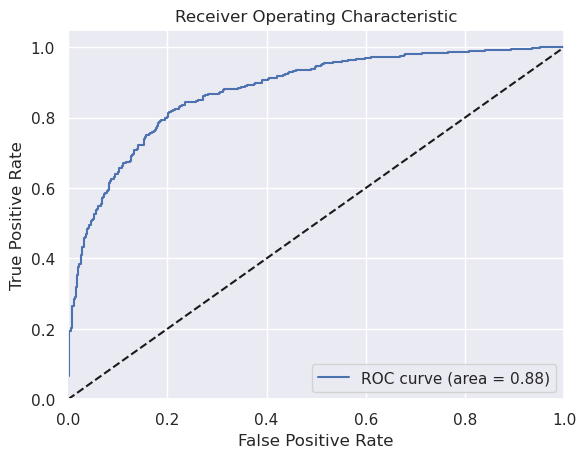

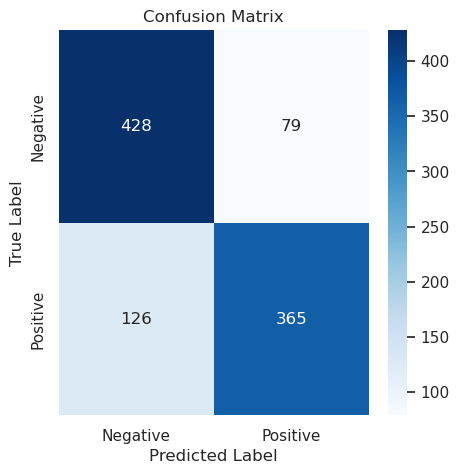

In [27]:
# Evaluate the model on the test set
y_test_preds = []
y_test_trues = []
predlist = []

model.eval()

with torch.no_grad():
    for data in loader_valid:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.round(outputs)
        predlist += predicted.cpu().detach().numpy().tolist()
        outputs = torch.sigmoid(outputs)
        y_test_preds += outputs.cpu().detach().numpy().tolist()
        y_test_trues += labels.cpu().detach().numpy().tolist()

# Calculate AUC ROC score
auc_roc_score = roc_auc_score(y_test_trues, y_test_preds)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_trues, y_test_preds)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_trues, predlist)

# Plot confusion matrix
labels = ['Negative', 'Positive']
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mat, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()